# Read data

I will use the data scraper with the movie_scraper project. The datafile contains an array of json objects, which will be transformed into a pandas dataframe to prepare the dataset for the ml task.

In [382]:
import json
import pandas as pd

with open('../movie_scraper/data/movies.json', 'r') as data_file:
    json_data = data_file.read()

df = pd.DataFrame(json.loads(json_data))

In [383]:
df.head()

,description,genre,story_line,title,year
0,The story of a tourist family in Thailand caug...,"[Drama, History, Thriller]","A regular family - Maria (Naomi Watts), Henry ...",The Impossible,2012
1,"In Nazi-occupied France during World War II, a...","[Adventure, Drama, War]","In German-occupied France, young Jewish refuge...",Inglourious Basterds,2009
2,"In a future where mutants are nearly extinct, ...","[Action, Drama, Sci-Fi, Thriller]",In 2029 the mutant population has shrunken sig...,Logan,2017
3,Following the events of Avengers: Endgame (201...,"[Action, Adventure, Sci-Fi]",Peter Parker's world has changed a lot since t...,Spider-Man: Far from Home,2019
4,"Marty McFly, a 17-year-old high school student...","[Adventure, Comedy, Sci-Fi]","Marty McFly, a typical American teenager of th...",Back to the Future,1985


The process to follow for the LDA implementation below will be:
* Read data
* cleanup/pre-process text data
* exploratory analysis
* transform documents to a vectorized form (prepare data for LDA)
* Model evaluation and parameter tunning

# Preprocess text

I will use the movie story line as the documents in corpus. The pipeline defines a simple NLP cleaning, mostly used in all standard processing text pipelines for machine learning tasks.
1. split document into tokens
2. lemmatize the tokens
3. compute bigrams
4. compute bag-of-words representation of data

for the first task I will use the regex tokenizer from NLTK. I will apply also lower case to tokens, remove numbers and remove one single characters.

In [384]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

stops = set(stopwords.words("english"))

tokenizer = RegexpTokenizer(r'\w+')
df['story_line'] = df['story_line'].apply(lambda x: x.lower())
df['story_line'] = df['story_line'].apply(lambda x: tokenizer.tokenize(x))
df['story_line'] = df['story_line'].apply(lambda x: [token for token in x if token not in stops])
df['story_line'] = df['story_line'].apply(lambda x: [token for token in x if not token.isnumeric()])
df['story_line'] = df['story_line'].apply(lambda x: [token for token in x if len(token) > 1])

every row in the story line field contains now a list of tokens we can iterate and cleanup further

In [385]:
df.head()

,description,genre,story_line,title,year
0,The story of a tourist family in Thailand caug...,"[Drama, History, Thriller]","[regular, family, maria, naomi, watts, henry, ...",The Impossible,2012
1,"In Nazi-occupied France during World War II, a...","[Adventure, Drama, War]","[german, occupied, france, young, jewish, refu...",Inglourious Basterds,2009
2,"In a future where mutants are nearly extinct, ...","[Action, Drama, Sci-Fi, Thriller]","[mutant, population, shrunken, significantly, ...",Logan,2017
3,Following the events of Avengers: Endgame (201...,"[Action, Adventure, Sci-Fi]","[peter, parker, world, changed, lot, since, ev...",Spider-Man: Far from Home,2019
4,"Marty McFly, a 17-year-old high school student...","[Adventure, Comedy, Sci-Fi]","[marty, mcfly, typical, american, teenager, ei...",Back to the Future,1985


Lemmatisation in linguistics is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form. I will use the wordNet lemmatizer from NLTK, the reason to use llematisation in this use case is because a lemmatizer produces more readable words and are normally prefered for topic modelling.

In [386]:
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

df['story_line'] = df['story_line'].apply(lambda x: [lemmatizer.lemmatize(token) for token in x])

Next step is to compute the bigrams. Bigrams are sets of two adjacent words and are useful to encapsule the usage of words in their context.

In [387]:
from gensim.models import Phrases

docs = df['story_line'].tolist()
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            docs[idx].append(token)

now I will remove rare words (in less than 10 story lines) and common words based on their document frequency (that happend in more than the 30% of the story lines).

In [388]:
from gensim.corpora import Dictionary

dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=0.3)

Last step is to transform the documents to a vecgorized form. This is performed by computing the frequency of each word.

In [389]:
corpus = [dictionary.doc2bow(doc) for doc in docs]

print(f'Number of unique tokens: {len(dictionary)}')
print(f'Number of documents: {len(corpus)}')

Number of unique tokens: 1004
Number of documents: 1000


Before going to the modeling part, I want to double check that our data was cleaned properly and we can extract visual information from the tokens I created. For this I will create a wordcloud for the words in our corpus.

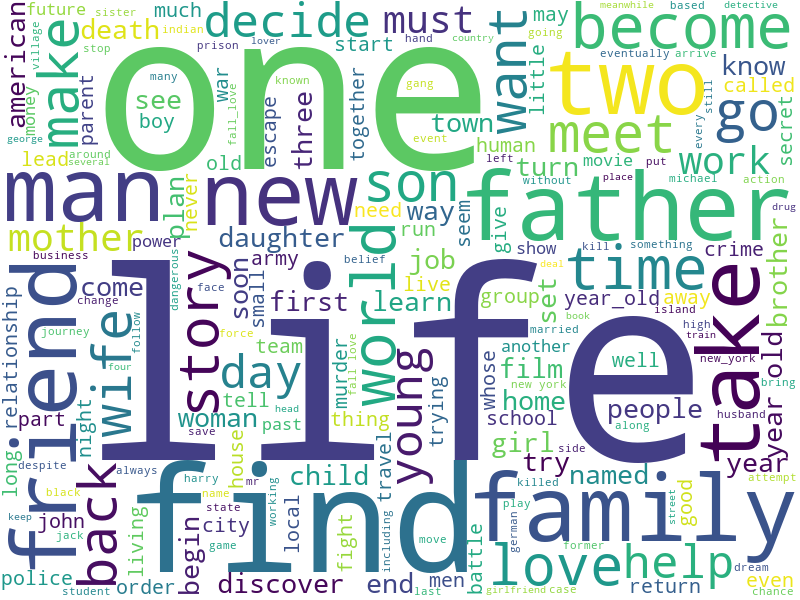

In [390]:
from wordcloud import WordCloud

text = [' '.join(doc) for doc in docs]
text = ' '.join(text)
wordcloud = WordCloud(background_color="white", width=800, height=600)
wordcloud.generate(text)
wordcloud.to_image()

The results of the wordlcoud don't show a big difference or special distinction of words within the corpus. I will see if the description column is able to show better results before deciding if I should continue with Story line for topic modeling or the description of a movie.

In [391]:
def clean_text(row):
    row = row.lower()
    row = tokenizer.tokenize(row)
    row = [token for token in row if token not in stops]
    row = [token for token in row if not token.isnumeric()]
    row = [token for token in row if len(token) > 1]
    row = [lemmatizer.lemmatize(token) for token in row]
    return row

def create_bigram(serie: pd.Series) -> list:
    docs = serie.tolist()
    bigram = Phrases(docs, min_count=20)
    for idx in range(len(docs)):
        for token in bigram[docs[idx]]:
            if '_' in token:
                docs[idx].append(token)
    return docs

df['description'] = df['description'].apply(clean_text)
dscr_docs = create_bigram(df['description'])

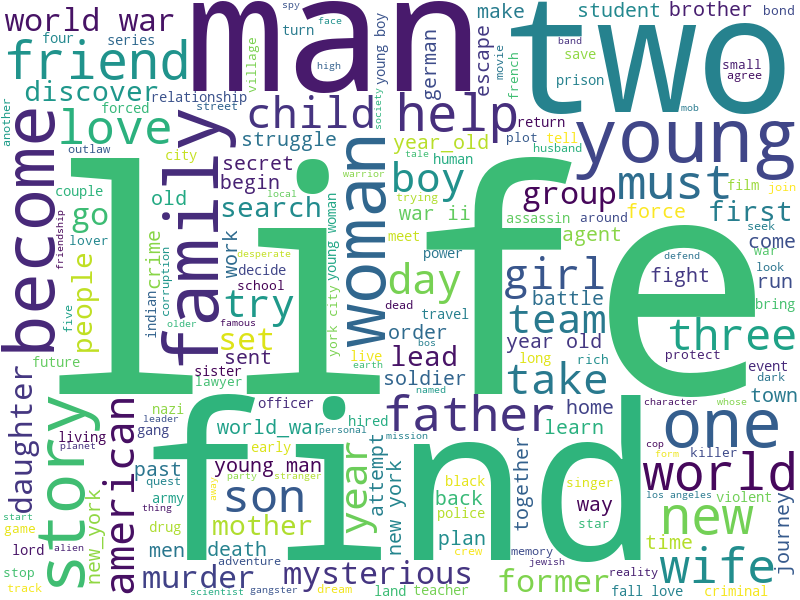

In [392]:
text = [' '.join(doc) for doc in dscr_docs]
text = ' '.join(text)
wordcloud = WordCloud(background_color="white", width=800, height=600)
wordcloud.generate(text)
wordcloud.to_image()

In [393]:
dscr_dictionary = Dictionary(dscr_docs)
dscr_dictionary.filter_extremes(no_below=10, no_above=0.3)
dscr_corpus = [dscr_dictionary.doc2bow(doc) for doc in dscr_docs]

print(f'Number of unique tokens: {len(dscr_dictionary)}')
print(f'Number of documents: {len(dscr_corpus)}')

Number of unique tokens: 238
Number of documents: 1000


The plot of the worcloud shows that the frequency of words happen similarly in between story_line and description but the advantage of the second is that we have reduces the corpus dictionary to 238 words.
Let's see which text is better used to model the topics.

# Train LDA Model

Now that I have the data prepared for the main objective of this analysis, the next step will be to define the training parameters of the model. The most important here is the number of topics I want to model in the data, this is a parameter that needs to be defined upfront and is part of most unsupervides clustering techniques. 

Our application as a sample one is a bit easier because I've already extracted the genres of movies, let's interprate and label the genre as the topic we want to model and the numebr defined will be first 5, 10 and lastly 21. 21 is total amount of genres available in the dataset from IMDB. 

The second parameter is the chunksize which controls the amount of documents are processed at a time in the training. As we have 1000 documents, let's process them all at once.

The third parameter is passes, which is the equal to epochs (how oftenthe model is trained in the entire corpus).

The fourth parameter is the iterations, which controls how often we repeat a loop over each document.

eval_every enables logging information for the training phase, this will help us to check if the documents have converged with the numnber of passes and iterations.

In [394]:
# Set training parameters.
num_topics = 5
chunksize = 1000
passes = 20
iterations = 400
eval_every = 10

In [396]:
from gensim.models import LdaModel

tmp = dictionary[0]
id2word = dictionary.id2token

%time model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, alpha='auto', eta='auto', iterations=iterations, num_topics=num_topics, passes=passes, eval_every=eval_every)

CPU times: user 20.8 s, sys: 58.6 ms, total: 20.9 s
Wall time: 21 s


Let's check on the topics and their distribution probability for each of the words in the model.

In [397]:
model.show_topics()

[(0,
  '0.017*"one" + 0.013*"life" + 0.011*"find" + 0.009*"time" + 0.009*"man" + 0.008*"town" + 0.007*"two" + 0.007*"friend" + 0.006*"world" + 0.006*"story"'),
 (1,
  '0.020*"life" + 0.014*"love" + 0.013*"year" + 0.009*"young" + 0.009*"old" + 0.009*"get" + 0.009*"friend" + 0.009*"family" + 0.008*"one" + 0.008*"girl"'),
 (2,
  '0.012*"new" + 0.011*"life" + 0.009*"year" + 0.009*"one" + 0.008*"go" + 0.008*"world" + 0.007*"story" + 0.007*"want" + 0.007*"father" + 0.007*"son"'),
 (3,
  '0.014*"find" + 0.012*"man" + 0.011*"must" + 0.011*"get" + 0.009*"one" + 0.009*"way" + 0.008*"life" + 0.008*"two" + 0.007*"father" + 0.007*"family"'),
 (4,
  '0.013*"police" + 0.012*"wife" + 0.012*"two" + 0.011*"take" + 0.009*"one" + 0.009*"force" + 0.008*"get" + 0.007*"town" + 0.007*"son" + 0.007*"crime"')]

I can see a lot of noise from the stopwords basically. a good library to visualize the results of the LDA model is the PyLDAViz:

In [398]:
import pyLDAvis.gensim

viz = pyLDAvis.gensim.prepare(model, corpus, dictionary)
pyLDAvis.display(viz)

/anaconda3/envs/AmberScript/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


The results of the model for 5 categories make sense at a higher level. We can see the following:
1. topic 1 and 2 are close to each other with words that relate to family and real story based movies.
2. topic 3 is closer to 2 and 1 but more related to action movies with terms like prision, new life, city, death and drugs.
3. topic 4 is related to crime and police films.
4. topic 5 seems to be related to drama/crime films.

let's see if we can get more granular with the topics

In [399]:
# Set training parameters.
num_topics = 10
# chunksize = 1000
# passes = 20
# iterations = 400
# eval_every = 10

tmp = dictionary[0]
id2word = dictionary.id2token

%time model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, alpha='auto', eta='auto', iterations=iterations, num_topics=num_topics, passes=passes, eval_every=eval_every)

CPU times: user 18.6 s, sys: 93.4 ms, total: 18.7 s
Wall time: 18.9 s


In [400]:
model.show_topics()

[(0,
  '0.014*"man" + 0.011*"one" + 0.011*"life" + 0.010*"war" + 0.010*"year" + 0.010*"young" + 0.009*"two" + 0.009*"time" + 0.008*"find" + 0.008*"family"'),
 (1,
  '0.023*"school" + 0.022*"friend" + 0.016*"life" + 0.013*"new" + 0.012*"year" + 0.010*"find" + 0.009*"father" + 0.009*"time" + 0.009*"old" + 0.008*"one"'),
 (2,
  '0.014*"one" + 0.014*"man" + 0.012*"team" + 0.012*"battle" + 0.011*"story" + 0.010*"find" + 0.010*"must" + 0.010*"war" + 0.010*"world" + 0.009*"mission"'),
 (3,
  '0.016*"one" + 0.010*"day" + 0.010*"life" + 0.009*"take" + 0.008*"two" + 0.008*"get" + 0.008*"man" + 0.008*"work" + 0.008*"time" + 0.007*"wife"'),
 (4,
  '0.029*"love" + 0.017*"year" + 0.014*"fall" + 0.012*"fall_love" + 0.012*"young" + 0.012*"story" + 0.011*"two" + 0.010*"man" + 0.009*"war" + 0.008*"later"'),
 (5,
  '0.015*"life" + 0.012*"indian" + 0.009*"time" + 0.008*"world" + 0.008*"film" + 0.008*"man" + 0.008*"one" + 0.007*"game" + 0.007*"back" + 0.007*"well"'),
 (6,
  '0.013*"family" + 0.013*"get" + 

In [401]:
viz = pyLDAvis.gensim.prepare(model, corpus, dictionary)
pyLDAvis.display(viz)

/anaconda3/envs/AmberScript/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [402]:
# Set training parameters.
num_topics = 21
# chunksize = 1000
# passes = 20
# iterations = 400
# eval_every = 10
tmp = dictionary[0]
id2word = dictionary.id2token

%time model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, alpha='auto', eta='auto', iterations=iterations, num_topics=num_topics, passes=passes, eval_every=eval_every)

CPU times: user 16.3 s, sys: 49.1 ms, total: 16.4 s
Wall time: 16.4 s


In [403]:
model.show_topics()

[(19,
  '0.016*"town" + 0.013*"come" + 0.013*"go" + 0.012*"friend" + 0.012*"home" + 0.011*"way" + 0.010*"father" + 0.010*"back" + 0.010*"find" + 0.010*"chance"'),
 (9,
  '0.017*"story" + 0.017*"man" + 0.017*"black" + 0.016*"one" + 0.013*"white" + 0.012*"woman" + 0.011*"dr" + 0.010*"life" + 0.010*"death" + 0.010*"wall"'),
 (1,
  '0.017*"life" + 0.013*"year" + 0.013*"find" + 0.013*"young" + 0.011*"james" + 0.011*"story" + 0.010*"man" + 0.010*"town" + 0.009*"like" + 0.009*"father"'),
 (18,
  '0.021*"find" + 0.014*"life" + 0.013*"one" + 0.012*"son" + 0.012*"new" + 0.011*"young" + 0.010*"man" + 0.010*"day" + 0.009*"town" + 0.008*"help"'),
 (11,
  '0.027*"life" + 0.015*"new" + 0.014*"job" + 0.013*"live" + 0.011*"love" + 0.011*"year" + 0.010*"first" + 0.010*"american" + 0.009*"man" + 0.009*"movie"'),
 (5,
  '0.018*"life" + 0.018*"story" + 0.014*"find" + 0.012*"one" + 0.012*"war" + 0.010*"two" + 0.008*"must" + 0.008*"soon" + 0.008*"john" + 0.007*"world"'),
 (2,
  '0.014*"get" + 0.010*"police" 

In [404]:
viz = pyLDAvis.gensim.prepare(model, corpus, dictionary)
pyLDAvis.display(viz)

/anaconda3/envs/AmberScript/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Let's see how it changes if I decide to use the description over the story line

In [405]:
# Set training parameters.
num_topics = 21
# chunksize = 1000
# passes = 20
# iterations = 400
# eval_every = 10

tmp = dscr_dictionary[0]
id2word = dscr_dictionary.id2token

%time model = LdaModel(corpus=dscr_corpus, id2word=id2word, chunksize=chunksize, alpha='auto', eta='auto', iterations=iterations, num_topics=num_topics, passes=passes, eval_every=eval_every)

CPU times: user 7.54 s, sys: 11.8 ms, total: 7.55 s
Wall time: 7.55 s


In [406]:
model.show_topics()

[(7,
  '0.070*"event" + 0.058*"series" + 0.053*"power" + 0.048*"death" + 0.047*"decides" + 0.045*"find" + 0.040*"hollywood" + 0.035*"mission" + 0.035*"help" + 0.033*"mysterious"'),
 (3,
  '0.083*"day" + 0.070*"begin" + 0.069*"man" + 0.053*"prison" + 0.044*"life" + 0.043*"see" + 0.038*"quest" + 0.030*"career" + 0.020*"los" + 0.020*"angeles"'),
 (13,
  '0.076*"people" + 0.064*"find" + 0.063*"gang" + 0.046*"discovers" + 0.045*"meet" + 0.035*"must" + 0.034*"around" + 0.032*"man" + 0.031*"love" + 0.028*"future"'),
 (0,
  '0.083*"father" + 0.070*"son" + 0.061*"set" + 0.048*"world" + 0.042*"learns" + 0.042*"young" + 0.038*"return" + 0.038*"home" + 0.034*"famous" + 0.034*"help"'),
 (19,
  '0.078*"high" + 0.074*"friend" + 0.060*"come" + 0.059*"two" + 0.047*"battle" + 0.044*"school" + 0.040*"student" + 0.040*"criminal" + 0.030*"former" + 0.030*"british"'),
 (4,
  '0.179*"war" + 0.149*"world" + 0.106*"world_war" + 0.077*"ii" + 0.046*"german" + 0.034*"way" + 0.029*"life" + 0.029*"jewish" + 0.022*"

In [407]:
viz = pyLDAvis.gensim.prepare(model, dscr_corpus, dscr_dictionary)
pyLDAvis.display(viz)

/anaconda3/envs/AmberScript/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


# Doc-Topic distribution

I will use the get_document_topics to infer the topic distribution of a document. LDA returns the topic probability distribution for each document in the input corpus.

In [408]:
all_topics = model.get_document_topics(dscr_corpus, minimum_probability=0)
all_topics[0]

[(0, 0.010063182),
 (1, 0.010127504),
 (2, 0.010089152),
 (3, 0.009787131),
 (4, 0.010584206),
 (5, 0.011071644),
 (6, 0.010171812),
 (7, 0.009553126),
 (8, 0.010101014),
 (9, 0.010770879),
 (10, 0.010940117),
 (11, 0.010306024),
 (12, 0.79403204),
 (13, 0.009963927),
 (14, 0.010236085),
 (15, 0.010906158),
 (16, 0.010183861),
 (17, 0.010314965),
 (18, 0.010547062),
 (19, 0.0100827515),
 (20, 0.0101673575)]

In [409]:
all_topics_dscr = model.get_document_topics(dscr_corpus, minimum_probability=0)
all_topics_dscr[0]

[(0, 0.010063182),
 (1, 0.010127504),
 (2, 0.010089152),
 (3, 0.009787131),
 (4, 0.010584206),
 (5, 0.011071644),
 (6, 0.010171812),
 (7, 0.009553126),
 (8, 0.010101014),
 (9, 0.010770879),
 (10, 0.010940117),
 (11, 0.010306024),
 (12, 0.79403204),
 (13, 0.009963927),
 (14, 0.010236085),
 (15, 0.010906158),
 (16, 0.010183861),
 (17, 0.010314965),
 (18, 0.010547062),
 (19, 0.0100827515),
 (20, 0.0101673575)]

The above output shows the topic distribution of first document in the corpus as a list of (topic_id, topic_probability).
Now, using the topic distribution of a document as it's vector embedding, we will plot all the documents in our corpus using Tensorboard.

## Prepare the Input files for Tensorboard

To be able to use tensorboard I need to produce two input files, one containing the vectors for the document and the other containing the metadata. The topic distribution of documents will be the vector and the metadata will be the movie titles with their genres. The genres will be quite interesting to view in the space as I extracted as list, I could review if the topic modeling technique was able to cluster together combination of genres by the story line.

In [410]:
# create file for tensors
with open('../movie_scraper/data/doc_lda_tensor.tsv','w') as w:
    for doc_topics in all_topics:
        for topics in doc_topics:
            w.write(str(topics[1])+ "\t")
        w.write("\n")
        
# create file for metadata
tensors = []
for doc_topics in all_topics:
    doc_tensor = []
    for topic in doc_topics:
        if round(topic[1], 3) > 0:
            doc_tensor.append((topic[0], float(round(topic[1], 3))))
    # sort topics according to highest probabilities
    doc_tensor = sorted(doc_tensor, key=lambda x: x[1], reverse=True)
    # store vectors to add in metadata file
    tensors.append(doc_tensor[:5])

i=0
with open('../movie_scraper/data/doc_lda_metadata.tsv','w') as w:
    w.write('Titles\tGenres\n')
    for j,k in zip(df.title, df.genre):
        w.write("%s\t%s\n" % (''.join((str(j), str(tensors[i]))),k))
        i+=1

In [411]:
# create file for tensors
with open('../movie_scraper/data/doc_lda_tensor_description.tsv','w') as w:
    for doc_topics in all_topics_dscr:
        for topics in doc_topics:
            w.write(str(topics[1])+ "\t")
        w.write("\n")
        
# create file for metadata
tensors = []
for doc_topics in all_topics_dscr:
    doc_tensor = []
    for topic in doc_topics:
        if round(topic[1], 3) > 0:
            doc_tensor.append((topic[0], float(round(topic[1], 3))))
    # sort topics according to highest probabilities
    doc_tensor = sorted(doc_tensor, key=lambda x: x[1], reverse=True)
    # store vectors to add in metadata file
    tensors.append(doc_tensor[:5])

i=0
with open('../movie_scraper/data/doc_lda_metadata_description.tsv','w') as w:
    w.write('Titles\tGenres\n')
    for j,k in zip(df.title, df.genre):
        w.write("%s\t%s\n" % (''.join((str(j), str(tensors[i]))),k))
        i+=1

Now, as the topic distribution of a document is used as it’s embedding vector, t-sne ends up forming clusters of documents belonging to same topics. In order to understand and interpret about the theme of those topics, we can use show_topic() to explore the terms that the topics consisted of.

# Interpreting clusters of topics in Tensorboard

Finally I wanted to load the previous files into Tensorboard to be able to plot the vectors for each of the documents and their topic distribution, and check if these make sense.
In the following picture We can check that with the limited amount of data we have, some clusters make sense, romantic movies for example are all cluster together and based on the tensors created (topicid, probability) movies like **"HER"** are close to other movies where both guys end up alone at the end **"Moulin Rogue"**

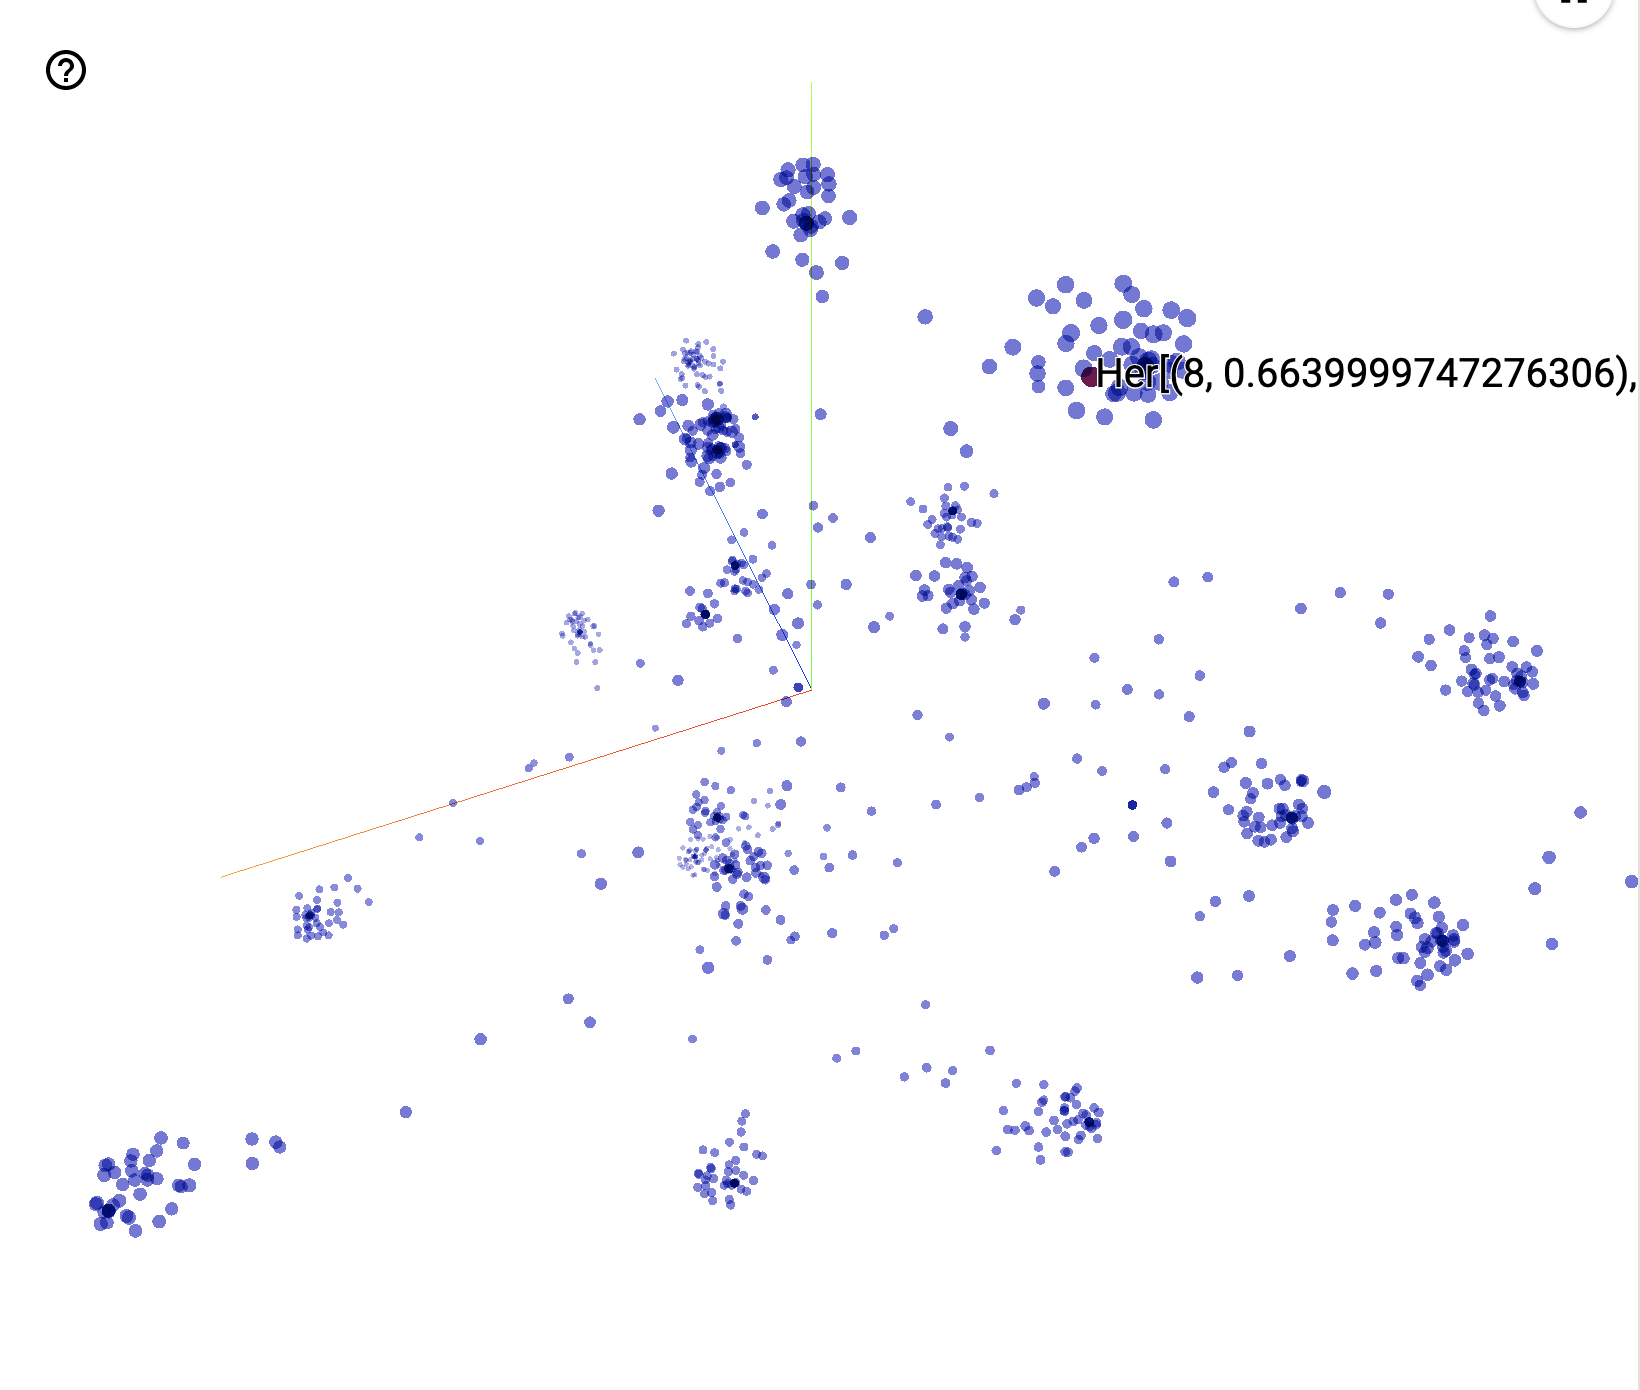

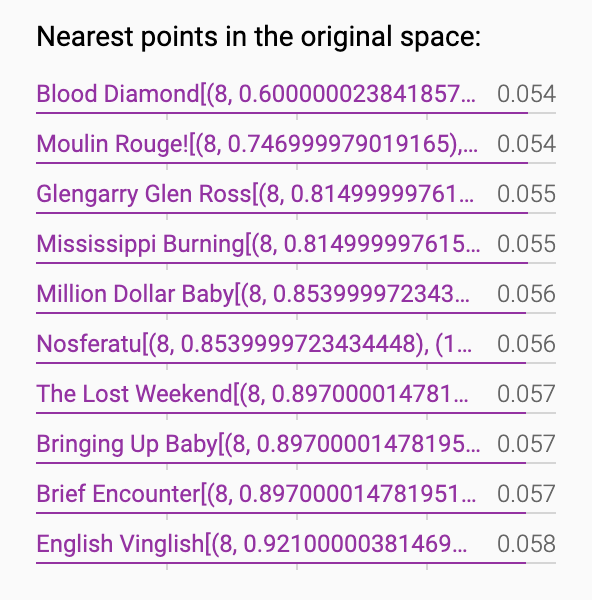

# Last Step:

Now that I have trained and assume whcih one dataset and parameters can be used for our "production" model, I can then wrap the entire process into functions, save the model to disk and create the inference function to get the topic distribtuon of an unseen document.

In [412]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Phrases
from gensim.corpora import Dictionary
from nltk.corpus import stopwords

tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
stops = set(stopwords.words("english"))

def clean_text(row):
    row = row.lower()
    row = tokenizer.tokenize(row)
    row = [token for token in row if token not in stops]
    row = [token for token in row if not token.isnumeric()]
    row = [token for token in row if len(token) > 1]
    row = [lemmatizer.lemmatize(token) for token in row]
    return row

In [413]:
# Toy Story 4 description
text = "When a new toy called \"Forky\" joins Woody and the gang, a road trip alongside old and new friends reveals how big the world can be for a toy."
bow = dscr_dictionary.doc2bow(clean_text(text))

# print(bow)
# print(id2word[258])

lda_vector = model[bow]
# print(lda_vector)

print(model.print_topic(max(lda_vector, key=lambda item: item[1])[0]))

0.146*"year" + 0.128*"old" + 0.071*"year_old" + 0.065*"woman" + 0.064*"young" + 0.042*"man" + 0.039*"two" + 0.038*"life" + 0.034*"new" + 0.026*"friendship"


In [418]:
# Saving Private Ryan description
text = "Following the Normandy Landings, a group of U.S. soldiers go behind enemy lines to retrieve a paratrooper whose brothers have been killed in action."
bow = dscr_dictionary.doc2bow(clean_text(text))
lda_vector = model[bow]
print(model.print_topic(max(lda_vector, key=lambda item: item[1])[0]))

0.077*"story" + 0.051*"first" + 0.047*"struggle" + 0.039*"brother" + 0.039*"year" + 0.037*"former" + 0.034*"put" + 0.034*"best" + 0.031*"true" + 0.031*"tell"


In [423]:
# store trained models to disk
model.save('model/lda_imdb.model')
dscr_dictionary.save('model/imdb.dictionary')

In [425]:
# small application
from gensim.models import LdaModel

lda = LdaModel.load('model/lda_imdb.model')
bow = dscr_dictionary.doc2bow(clean_text(text))
vector = lda[bow]

In [444]:
lda.print_topic(max(vector, key=lambda item: item[1])[0])

'0.077*"story" + 0.051*"first" + 0.047*"struggle" + 0.039*"brother" + 0.039*"year" + 0.037*"former" + 0.034*"put" + 0.034*"best" + 0.031*"true" + 0.031*"tell"'

# Finish

The model was saved to disk along with the ictionary, the model can be loaded back and updated using the update method from gensim. In the script in the root directory you have the small application that receives a text and produces the topic distribution based on the trained LDA model.